In [23]:
import numpy as np
import os
import cv2 as cv

import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf 

import matplotlib.pyplot as plt

from skimage.filters import sobel
from keras.preprocessing.sequence import pad_sequences

<h1>Load in Files<h1>

<h3> Preprocessing Functions <h3>

In [162]:
#Helper function to pad np array to max(n,m) x max(n,m) if array is nxm
def squarify(M,val=0,change_dim=0):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)

def otsuize(image,v=1,classes=5):
    from skimage.filters import threshold_multiotsu, median
    # Applying multi-Otsu threshold for the default value, generating
    # three classes.
    thresholds = threshold_multiotsu(image,classes)

    # Using the threshold values, we generate the  regions.
    regions = np.digitize(image, bins=thresholds)
    regions[regions>v]=0
    regions[regions<v]=0
    return regions#was median(regions)

def stackify(mask_in,kernel_size = (3,3),iterations_a=2,iterations_b=1):
    #img = np.random.rand(a.shape[0],a.shape[1],3)#cv.imread('coins.png')
    gray = mask_in#mymask[1]#cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(gray,0,1,cv.THRESH_BINARY_INV)

    kernel = np.ones(kernel_size,np.uint8)
    opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations_a)

    # sure background area
    sure_bg = cv.dilate(opening,kernel,iterations_b)
    # Finding sure foreground area
    dist_transform = cv.distanceTransform(opening,cv.DIST_L2,0)
    ret, sure_fg = cv.threshold(dist_transform,0.05*dist_transform.max(),255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg,sure_fg)

    # Marker labelling
    ret, markers = cv.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    #markers = cv.watershed(img.astype('uint8'),markers)
    #img[markers == -1] = [255,0,0]
    return markers

def maskify(mask_in):
    #img = np.random.rand(a.shape[0],a.shape[1],3)#cv.imread('coins.png')
    gray = mask_in#mymask[1]#cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(gray,0,1,cv.THRESH_BINARY_INV)

    kernel = np.ones((3,3),np.uint8)
    opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)

    # sure background area
    sure_bg = cv.dilate(opening,kernel,iterations=1)
    # Finding sure foreground area
    dist_transform = cv.distanceTransform(opening,cv.DIST_L2,0)
    ret, sure_fg = cv.threshold(dist_transform,0.1*dist_transform.max(),255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg,sure_fg)

    # Marker labelling
    ret, markers = cv.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    #markers = cv.watershed(img.astype('uint8'),markers)
    #img[markers == -1] = [255,0,0]
    return markers

<h3> Load files <h3>

<h3> Generator <h3>

In [267]:
import gc
def datagenerator(batchsize, mode="train"):
    vol_start = np.random.randint(low=100,high = 550)
    vol_end = vol_start+10

    stack_path = os.path.join("C:\\","Users","15714","Desktop","OA Research","TSP and OA","MATs")
    mask_path = os.path.join("C:\\","Users","15714","Desktop","OA Research","TSP and OA","Final Masks","femMeta")

    stack_files_npy=[]
    mask_files_npy=[]
    # Generate data
    for file in os.listdir(stack_path):
        if file.endswith(".npy"):
            stack_files_npy.append(os.path.join(stack_path, file))

    for file in os.listdir(mask_path):
        if file.endswith(".npy"):
            mask_files_npy.append(os.path.join(mask_path, file))


                
    while True:
        start = 0
        end = batchsize
        #batchsize sets steps per batch
        while start  < len(stack_files_npy): 
            print("start",start,"\r\n")
            x = np.load(stack_files_npy[start])[vol_start:vol_end,:512,:512]
            x[x<0]=0
            print(x.shape)
            for i in range(0,x.shape[0]):
                x[i]=sobel(x[i])
            y = np.load(mask_files_npy[start])[vol_start:vol_end,:512,:512]

            print("x shape", x.shape,"\r\n")
            print("y shape",y.shape)
            yield np.expand_dims(x, axis=-1).astype('float32'), np.expand_dims(y, axis=-1).astype('float32')
            gc.collect()
            start += batchsize
            end += batchsize

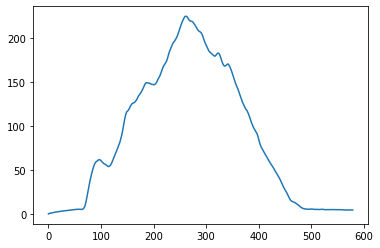

In [250]:
x[x<0]=0
plt.plot(np.mean((np.mean(x,axis=1)),axis=1))

<h1>Loss Functions<h1>

In [20]:
epsilon = 1e-5
smooth = 1

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall

def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 

def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)




<h1>Unet<h1>


In [21]:
#from zhixuhao


def unet(pretrained_weights = None,input_size = (128,128,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9=up9
    merge9 = concatenate([conv1,up9], axis = 3)#was out
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-5), loss = bce_dice_loss, metrics = tf.keras.metrics.MeanIoU(num_classes=2, name=None, dtype=None))#loss=focal_tversky

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model


<h2> Run Unet <h2>

In [268]:
keras.backend.clear_session()
model = unet(input_size = (512,512,1))
#where to save model
filepath = "femMeta-bcedice-3-6"

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_weights_only=False,mode='min')
callbacks_list = [checkpoint]


train_gen = datagenerator(1)
history = model.fit(train_gen,epochs=1)

start 0 

(10, 512, 512)
x shape (10, 512, 512) 

y shape (10, 512, 512)
start 1 

(10, 512, 512)
x shape (10, 512, 512) 

y shape (10, 512, 512)
      1/Unknown - 71s 71s/step - loss: 1.6932 - mean_io_u: 1.0000start 2 

(10, 512, 512)
x shape (10, 512, 512) 

y shape (10, 512, 512)
      2/Unknown - 146s 75s/step - loss: 1.6715 - mean_io_u: 0.7441start 3 

(10, 512, 512)
x shape (10, 512, 512) 

y shape (10, 512, 512)
      3/Unknown - 261s 95s/step - loss: 1.6643 - mean_io_u: 0.6588start 4 

(10, 512, 512)
x shape (10, 512, 512) 

y shape (10, 512, 512)
      4/Unknown - 378s 103s/step - loss: 1.6635 - mean_io_u: 0.6170start 5 

(10, 512, 512)
x shape (10, 512, 512) 

y shape (10, 512, 512)


KeyboardInterrupt: 

<h3>Predictions and Results <h3>

In [9]:
#f, axarr = plt.subplots(5,3,figsize=(40,40),squeeze=True)#,gridspec_kw={'wspace':0, 'hspace':0})

#f.subplots_adjust(wspace=0, hspace=0)


#tight boxes option
nrow = u_stack.shape[0]
ncol = 4
fig, axarr = plt.subplots(
    nrow, ncol,
    gridspec_kw=dict(wspace=0.0, hspace=0.0,
                     top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                     left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1)),
    figsize=(ncol + 1, nrow + 1),
    sharey='row', sharex='col', #  optionally
)



for i in range(nrow):
    #axarr[i,0].imshow(u_mask[i])
    #axarr[i,1].imshow(cv2.addWeighted( val_u_stack[40+i], 1, val_predict[40+i], .1, 0.0,dtype=cv2.CV_8UC3))
    axarr[i,0].imshow(predict[i])
    axarr[i,1].imshow(cv.addWeighted(np.float32(predict[i]), .7,np.float32(u_stack[i]/10000), .3,  0,dtype=5))
    axarr[i,2].imshow(u_stack[i])
    axarr[i,3].imshow(u_mask[i])
    print(i)

NameError: name 'u_stack' is not defined

<h3> Load model <h3>

In [ ]:
from keras.models import load_model
#need to pass custom loss
model_path = os.path.join("C:\\","Users","15714","Downloads","mac-3-4-ify-v-1","mac-3-4-ify-v-1")
model = load_model(model_path,custom_objects={'bce_dice_loss':bce_dice_loss})

In [ ]:
#predict on training 
pred = model.predict(u_stack)
#predict on testing
pred = model.predict

<h2> dev <h2>

In [ ]:
plt.imshow(u_stack[9].astype('int32'))

In [ ]:
from skimage.segmentation import flood,flood_fill
from skimage import filters
cat=a
#cat = #data.chelsea()
cat_sobel = a#filters.sobel(a)
cat_nose = flood(cat_sobel, (150, 100), tolerance=0.03)

fig, ax = plt.subplots(nrows=3, figsize=(10, 10))

ax[0].imshow(cat)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(
   filters.median(cat_sobel)
)
ax[1].set_title('Median filtered')
ax[1].axis('off')

ax[2].imshow(cat)
ax[2].imshow(cat_nose, alpha=1)
ax[2].plot(265, 240, 'wo')  # seed point
ax[2].set_title(' segmented with `flood`')
ax[2].axis('off')

fig.tight_layout()
plt.show()

TODO: try adding crop_center to u_stack forloop so we get middle, not just [:256],[:256]

In [ ]:
ind=40
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.filters import threshold_multiotsu

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# The input image.
image = mystack[ind]#data.camera()

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image,classes=5)

# Using the threshold values, we generate the  regions.
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the  thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

In [ ]:
from skimage import filters,data
low = 1000
high = low+3500
ind= 0
plt.imshow(filters.apply_hysteresis_threshold(filters.sobel(mystack[ind].astype('float32')), low=1000, high=4500))

In [ ]:
stack_slices = np.load(stack_files_npy[10])[100:150]
mask_slices = np.load(mask_files_npy[10])[100:150]

stack_list = []
mask_list = []
stack_like = np.zeros((stack_slices.shape[0],stack_slices.shape[0]))
mask_like = np.zeros((mask_slices.shape[0],mask_slices.shape[0]))

In [ ]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [ ]:
for i in range(stack_like.shape[0]):
    temp_stack = squarify(stack_slices[i],0,change_dim=1)
    temp_mask = squarify(mask_slices[i],0,change_dim=1)
    stack_list.append(crop_center(temp_stack,256,256))
    mask_list.append(crop_center(temp_mask,256,256))
    
u_stack = np.asarray(np.expand_dims(stack_list, axis=-1))
u_mask = np.expand_dims(mask_list, axis=-1)

#clear temp stuff out of memory
#del stack_slices,mask_slices,stack_list,mask_list,stack_like,mask_like

In [ ]:
pred_val = model.predict(u_stack)

In [ ]:
#f, axarr = plt.subplots(5,3,figsize=(40,40),squeeze=True)#,gridspec_kw={'wspace':0, 'hspace':0})

#f.subplots_adjust(wspace=0, hspace=0)


#tight boxes option
nrow = u_mask.shape[0]
ncol = 3
fig, axarr = plt.subplots(

    nrow, ncol,
    gridspec_kw=dict(wspace=0.0, hspace=0.0,
                     top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                     left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1)),
    figsize=(ncol + 1, nrow + 1),
    sharey='row', sharex='col', #  optionally

)
fig = plt.gcf()
fig.set_size_inches(110,80)


for i in range(u_mask.shape[0]):
    axarr[i,0].imshow(u_mask[i])
    #axarr[i,1].imshow(cv2.addWeighted( val_u_stack[40+i], 1, val_predict[40+i], .1, 0.0,dtype=cv2.CV_8UC3))
    axarr[i,1].imshow(predict[i])
    axarr[i,2].imshow(cv2.addWeighted(np.float32(pred_val[i]), 1,np.float32(u_stack[i]), .00001,  0,dtype=5))


In [ ]:
#f, axarr = plt.subplots(5,3,figsize=(40,40),squeeze=True)#,gridspec_kw={'wspace':0, 'hspace':0})

#f.subplots_adjust(wspace=0, hspace=0)


#tight boxes option
nrow = u_mask.shape[0]
ncol = 3
fig, axarr = plt.subplots(

    nrow, ncol,
    gridspec_kw=dict(wspace=0.0, hspace=0.0,
                     top=0.1, bottom=0,
                     left=0, right=0.01),
    #figsize=(ncol + 1, nrow + 1),
    sharey='row', sharex='col', #  optionally

)
fig.set_dpi(1000)


for i in range(u_mask.shape[0]):
    axarr[i,0].imshow(u_mask[i])
    #axarr[i,1].imshow(cv2.addWeighted( val_u_stack[40+i], 1, val_predict[40+i], .1, 0.0,dtype=cv2.CV_8UC3))
    axarr[i,1].imshow(predict[i])
    axarr[i,2].imshow(cv2.addWeighted(np.float32(pred_val[i]), 1,np.float32(u_stack[i]), .00001,  0,dtype=5))


In [ ]:
diff = u_mask - pred

In [ ]:
np.mean(diff)

In [ ]:
#load val
mask_path = "C:\\Users\\15714\\Desktop\\OA Research\\24 Micron Data\\MasksEpi"
mask_files = [os.path.join(mask_path,i) for i in os.listdir(mask_path)]
mask_files_npy = []
for file in os.listdir(mask_path):
    if file.endswith(".npy"):
        mask_files_npy.append(os.path.join(mask_path, file))

stacks_path = "C:\\Users\\15714\\Desktop\\OA Research\\24 Micron Data\\Stacks"
stacks_files = [os.path.join(stacks_path,i) for i in os.listdir(stacks_path)]
stack_files_npy = []

for file in os.listdir(stacks_path):
    if file.endswith(".npy"):
        stack_files_npy.append(os.path.join(stacks_path, file))
        
stack_slices = np.load(stack_files_npy[10])[175:250]
mask_slices = np.load(mask_files_npy[10])[175:250]

stack_list = []
mask_list = []
stack_like = np.zeros((stack_slices.shape[0],stack_slices.shape[0]))
mask_like = np.zeros((mask_slices.shape[0],mask_slices.shape[0]))

for i in range(stack_like.shape[0]):
    stack_list.append(squarify(stack_slices[i],0,change_dim=1)[:256,:256])
    mask_list.append(squarify(mask_slices[i],0,change_dim=1)[:256,:256])
    
val_u_stack = np.asarray(np.expand_dims(stack_list, axis=-1))
val_u_mask = np.expand_dims(mask_list, axis=-1)

#clear temp stuff out of memory
del stack_slices,mask_slices,stack_list,mask_list,stack_like,mask_like

In [ ]:
pred_val = model.predict(val_u_stack)

In [ ]:
diff_val = u_mask - pred_val

In [ ]:
np.mean(diff_val)

In [ ]:
def dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum



In [ ]:
mask_path = "C:\\Users\\15714\\Desktop\\OA Research\\24 Micron Data\\MasksEpi"
mask_files = [os.path.join(mask_path,i) for i in os.listdir(mask_path)]
mask_files_npy = []
for file in os.listdir(mask_path):
    if file.endswith(".npy"):
        mask_files_npy.append(os.path.join(mask_path, file))

stacks_path = "C:\\Users\\15714\\Desktop\\OA Research\\24 Micron Data\\Stacks"
stacks_files = [os.path.join(stacks_path,i) for i in os.listdir(stacks_path)]
stack_files_npy = []

for file in os.listdir(stacks_path):
    if file.endswith(".npy"):
        stack_files_npy.append(os.path.join(stacks_path, file))

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model("C:\\Users\\15714\\Downloads\\mac_model_long-3-2.hdf5",custom_objects = {"dice_loss":dice_loss})

In [ ]:
full_dice = []
for file_ind in range(47):
    print(file_ind)
    stack_slices = np.load(stack_files_npy[file_ind])[100:175]
    mask_slices = np.load(mask_files_npy[file_ind])[100:175]

    stack_list = []
    mask_list = []
    stack_like = np.zeros((stack_slices.shape[0],stack_slices.shape[0]))
    mask_like = np.zeros((mask_slices.shape[0],mask_slices.shape[0]))

    for i in range(stack_like.shape[0]):
        stack_list.append(squarify(stack_slices[i],0,change_dim=1)[:256,:256])
        mask_list.append(squarify(mask_slices[i],0,change_dim=1)[:256,:256])

    temp_u_stack = np.asarray(np.expand_dims(stack_list, axis=-1))
    temp_u_mask = np.expand_dims(mask_list, axis=-1)
    pred_mask = model.predict(temp_u_stack)
    temp_dice = []
 
    for img_ind in range(temp_u_stack.shape[0]):
        temp_dice.append(dice(temp_u_mask[img_ind],pred_mask[img_ind]))
        print(np.mean(np.asarray(temp_dice)))
    full_dice.append(np.asarray(temp_dice))

    #clear temp stuff out of memory
    del stack_slices,mask_slices,stack_list,mask_list,stack_like,mask_like

In [ ]:
np.mean(np.asarray(temp_dice))

In [ ]:
full_dice_np = np.asarray(full_dice)

In [ ]:
full_dice_np.shape

In [ ]:
plt.imshow(full_dice_np)

In [ ]:
np.argmin(np.mean(full_dice_np,axis=1))

In [ ]:
plt.plot(np.mean(full_dice_np,axis=1))

In [ ]:
plt.plot(np.mean(full_dice_np,axis=1))

In [ ]:
file_ind = 25

stack_slices = np.load(stack_files_npy[file_ind])[175:250]
mask_slices = np.load(mask_files_npy[file_ind])[175:250]

stack_list = []
mask_list = []
stack_like = np.zeros((stack_slices.shape[0],stack_slices.shape[0]))
mask_like = np.zeros((mask_slices.shape[0],mask_slices.shape[0]))

for i in range(stack_like.shape[0]):
    stack_list.append(squarify(stack_slices[i],0,change_dim=1)[:256,:256])
    mask_list.append(squarify(mask_slices[i],0,change_dim=1)[:256,:256])

temp_u_stack = np.asarray(np.expand_dims(stack_list, axis=-1))
temp_u_mask = np.expand_dims(mask_list, axis=-1)
pred_mask = model.predict(temp_u_stack)

In [ ]:
pred_mask = model.predict(temp_u_stack)

In [ ]:
temp_dice = []

for img_ind in range(temp_u_stack.shape[0]):
    temp_dice.append(dice(temp_u_mask[img_ind],pred_mask[img_ind]))

In [ ]:
np.argmin(np.asarray(full_dice_np))

In [ ]:
np.argpartition(np.mean(full_dice,axis=1),5)[:5]

In [ ]:
i = 1

In [ ]:
plt.imshow(temp_u_mask[i]-pred_mask[i])

In [ ]:
plt.imshow(temp_u_mask[i])

In [ ]:
plt.imshow(pred_mask[i])

In [ ]:
plt.imshow(temp_u_stack[i])

In [ ]:
plt.imshow(cv2.addWeighted(np.float32(pred_mask[i]), 1,np.float32(temp_u_stack[i]), .00009,  0,dtype=5))

In [ ]:
plt.imshow(cv2.addWeighted(np.float32(temp_u_mask[36]), 1,np.float32(temp_u_stack[36]), .00001,  0,dtype=5))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = temp_u_stack[i,:,:,0]# np.zeros((128, 128))
#im[32:-32, 32:-32] = 1

#im = ndi.gaussian_filter(im, 4)
#im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=9)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

In [ ]:
plt.imshow(cv2.addWeighted(np.float32(temp_u_mask[i]), 1,np.float32(temp_u_stack[i]), .0001,  0,dtype=5))

In [ ]:
i=70
im=temp_u_stack[i,:,:,0]
plt.imshow(cv2.addWeighted(np.float32(feature.canny(im, sigma=5)), 1,np.float32(temp_u_stack[i]), .0001,  0,dtype=5))

In [ ]:
temp = temp_u_mask[i,:,:,0]
#plt.imshow(feature.canny(temp,sigma=1))

plt.imshow(cv2.addWeighted(np.float32(edges2), .5,np.float32(feature.canny((temp).astype(np.float32),sigma=5)), 1,  0,dtype=5))

In [ ]:
i=70
plt.imshow(cv2.addWeighted(np.float32(temp_u_mask[i,:,:,0]), .5,np.float32(feature.canny((temp_u_mask[i,:,:,0]).astype(np.float32),sigma=5)), 1,  0,dtype=5))

In [ ]:
plt.imshow(feature.canny((temp_u_mask[i,:,:,0]).astype(np.float32),sigma=5))

In [ ]:
temp_u_mask.shape

In [ ]:
temp_u_mask[0,200]*2+1

In [ ]:
plt.hist(np.mean(full_dice,axis=1))

In [ ]:
plt.hist(temp_dice)

In [ ]:
#worst was 25

In [ ]:
full_std = []
for file_ind in range(47):
    stack_slices = np.load(stack_files_npy[file_ind])
    stack_list = []

    for i in range(300):
        stack_list.append(squarify(stack_slices[i],0,change_dim=1)[100:300][:256,:256])
 
    for img_ind in range(300):
        full_std.append(np.std((np.std(np.asarray(stack_list),axis=0))))
    print("index:",file_ind)

In [ ]:
np.mean(np.asarray(full_std[1]))

In [ ]:
full_std_np = np.asarray(full_std)

In [ ]:
full_std_np = full_std_np.reshape(47,-1)

In [ ]:
full_std_np = np.mean(full_std_np,axis=1)

In [ ]:
full_std_np.shape

In [ ]:
np.min(full_std_np)

In [ ]:
plt.hist(np.mean(full_dice_np,axis=1))

In [ ]:
np.argmax(full_std_np)

In [ ]:
full_std_np.shape

In [ ]:
N=10
np.argsort(full_std_np)[:10]

In [ ]:
N=10
np.argsort(pred_dice_ind)[:10]

In [ ]:
plt.plot(full_std_np)

In [ ]:
pred_dice_ind = np.mean(np.asarray(full_dice),axis=1)

In [ ]:
np.argmin(pred_dice_ind)

In [ ]:
plt.plot(pred_dice_ind)

In [ ]:
np.corrcoef(pred_dice_ind,full_std_np)[0,1]

In [15]:
u_stack = stacks[:,:,:,:,0]

In [5]:
u_stack = load_stacks(np.array([0]))

0
volume 0 loaded


In [6]:
u_mask = load_masks(np.array([0]))

0
shape (1, 652, 652, 1262)
volume 0 loaded


In [ ]:
#mask: 300-600

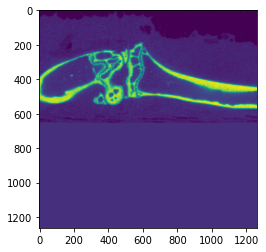

In [235]:
ind = 400
plt.imshow(u_stack[0,ind+5,:,:][:,:])

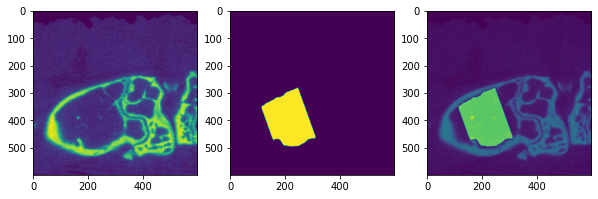

In [286]:

fig, ax = plt.subplots(ncols=ncol, figsize=(10, 10))
ind=450
a= u_stack[0,ind,:,:][:600,:600].astype('float32')
b=u_mask[0,ind,:,:][:600,:600].astype('float32')
ax[0].imshow(u_stack[0,ind,:,:][:600,:600])
ax[1].imshow(u_mask[0,ind,:,:][:600,:600])
ax[2].imshow(
    cv.addWeighted(
       a, 1e-4,b, .3,  0,dtype=5
    )
)

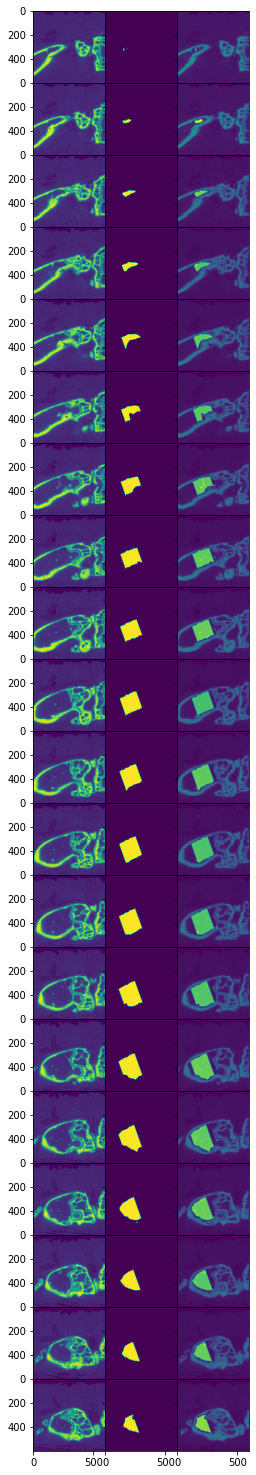

In [15]:
nrows = 20

ind=500
nrow = 20
ncol = 3
fig, ax = plt.subplots(

    nrow, ncol,
    gridspec_kw=dict(wspace=0.0, hspace=0.0,
                     top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                     left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1)),
    figsize=(ncol + 1, nrow + 1),
    sharey='row', sharex='col', #  optionally

)
#fig, ax = plt.subplots(ncols=3,nrows=nrows, figsize=(10, 10))
ind = 330
m=9
for i in range(nrows):
    ax[i,0].imshow(u_stack[0,ind+m*i,:,:][:600,:600])
    ax[i,1].imshow(u_mask[0,ind+m*i,:,:][:600,:600])
    ax[i,2].imshow(cv.addWeighted(np.float32(u_stack[0,ind+m*i,:,:][:600,:600]), 1e-4,np.float32(u_mask[0,ind+m*i,:,:][:600,:600]), .3,  0,dtype=5))

In [45]:
a.shape

(600, 600)

In [23]:
from skimage.filters import threshold_multiotsu, median
# Applying multi-Otsu threshold for the default value, generating
# three classes.
img = threshold_multiotsu(a,classes=2)
regions = np.digitize(img, bins=thresholds)


In [25]:
regions[0].shape

()

In [50]:
image.shape

(600, 600)

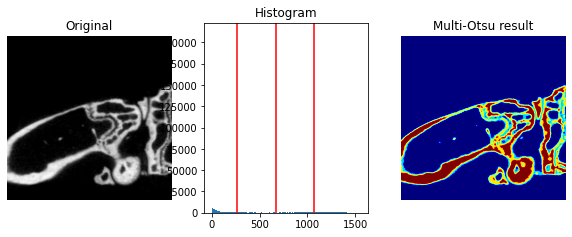

In [100]:
from skimage import data
from skimage.filters import threshold_multiotsu,median,apply_hysteresis_threshold


# The input image.
image = a#data.camera()

# Applying multi-Otsu threshold for the default value, generating
# three classes.
image[image<0]=0
thresholds = threshold_multiotsu(image,classes=4)

# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

In [224]:
a=u_stack[0,399,:,:][:600,:600]
c=np.copy(a)
c[c<800]=0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


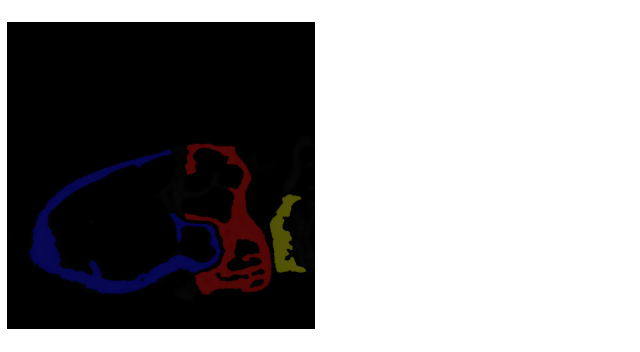

In [273]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import watershed
from skimage.color import label2rgb
from skimage import data

a=u_stack[0,450,:,:][:600,:600]
c=np.copy(a)

coins = c#data.coins()

# Make segmentation using edge-detection and watershed.
edges = sobel(c)

# Identify some background and foreground pixels from the intensity values.
# These pixels are used as seeds for watershed.
markers = np.zeros_like(coins)
foreground, background = 1, 2
markers[coins < 500.0] = background
markers[coins > 1500.0] = foreground

ws = watershed(edges, markers)
seg1 = label(ws == foreground)

# Show the segmentations.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5),
                         sharex=True, sharey=True)

color1 = label2rgb(seg1, image=coins, bg_label=0)
axes[0].imshow(color1)

for a in axes:
    a.axis('off')
fig.tight_layout()
plt.show()

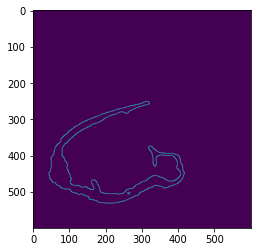

In [275]:
plt.imshow(canny(color1[:,:,2],sigma=2))

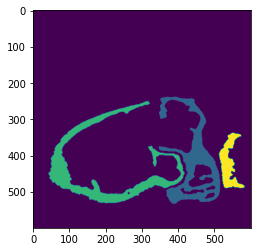

In [287]:
plt.imshow(seg1)

In [289]:
seg1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

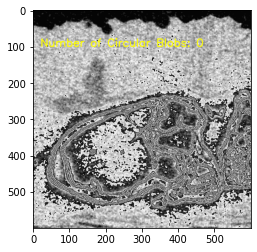

In [317]:
import cv2 
import numpy as np 
  
# Load image 
image = c.astype('uint8')#cv2.imread('C://gfg//images//blobs.jpg', 0) 
  
# Set our filtering parameters 
# Initialize parameter settiing using cv2.SimpleBlobDetector 
params = cv2.SimpleBlobDetector_Params() 
  
# Set Area filtering parameters 
params.filterByArea = True
params.minArea = 6000
  
# Set Circularity filtering parameters 
params.filterByCircularity = True 
params.minCircularity = 0.01
  
# Set Convexity filtering parameters 
params.filterByConvexity = True
params.minConvexity = 0.01
      
# Set inertia filtering parameters 
params.filterByInertia = True
params.minInertiaRatio = 0.01
  
# Create a detector with the parameters 
detector = cv2.SimpleBlobDetector_create(params) 
      
# Detect blobs 
keypoints = detector.detect(image) 
  
# Draw blobs on our image as red circles 
blank = np.zeros((1, 1))  
blobs = cv2.drawKeypoints(image, keypoints, blank, (0, 0, 255), 
                          cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
  
number_of_blobs = len(keypoints) 
text = "Number of Circular Blobs: " + str(len(keypoints)) 
cv2.putText(blobs, text, (20, 100), 
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2) 
  
# Show blobs 
plt.imshow(blobs)
#cv2.imshow("Filtering Circular Blobs Only", blobs) 
#cv2.waitKey(0) 
#cv2.destroyAllWindows() 

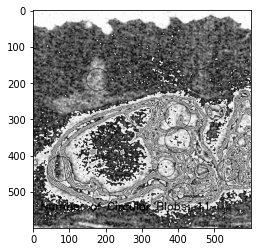

In [308]:
plt.imshow(blobs[:,:,2],cmap='Greys')

In [331]:
import matplotlib.pyplot as plt

from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

# Load picture, convert to grayscale and detect edges
image_rgb = c#data.coffee()[0:220, 160:420]
image_gray = c#color.rgb2gray(image_rgb)
edges = sobel(image_gray)# canny(image_gray, sigma=2.0,low_threshold=0.55, high_threshold=0.8)

# Perform a Hough Transform
# The accuracy corresponds to the bin size of a major axis.
# The value is chosen in order to get a single high accumulator.
# The threshold eliminates low accumulators
result = hough_ellipse(edges, accuracy=1, threshold=1,min_size=100, max_size=1000)
'''
result.sort(order='accumulator')

# Estimated parameters for the ellipse
best = list(result[-1])
yc, xc, a, b = [int(round(x)) for x in best[1:5]]
orientation = best[5]

# Draw the ellipse on the original image
cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
image_rgb[cy, cx] = (0, 0, 255)
# Draw the edge (white) and the resulting ellipse (red)
edges = color.gray2rgb(img_as_ubyte(edges))
edges[cy, cx] = (250, 0, 0)

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4), sharex=True,
                                sharey=True)

ax1.set_title('Original picture')
ax1.imshow(image_rgb)

ax2.set_title('Edge (white) and result (red)')
ax2.imshow(edges)

plt.show()
'''

KeyboardInterrupt: 

In [ ]:
plt.imshow(result)

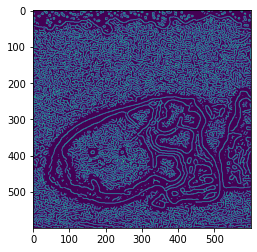

In [324]:
plt.imshow(edges)

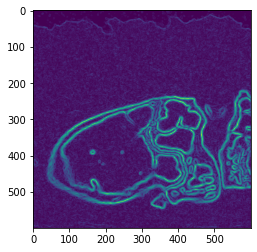

In [328]:
plt.imshow(sobel(c))

In [ ]:
import cv2
import numpy as np

cap = c#cv2.VideoCapture(1)
width = 320
height = 240
dim = (width, height)
while(True):
    gray = c#cv2.medianBlur(cv2.cvtColor(c, cv2.COLOR_BGR2GRAY),5)
    #resized = cv2.resize(gray,dim,interpolation = cv2.INTER_AREA)
    circ = cv2.HoughCircles(c.astype('uint8'),cv2.HOUGH_GRADIENT,1,50,param1=50,param2=35,minRadius=0,maxRadius=0)
    cv2.imshow('video',resized)
    if circ is not None:
        circ = np.uint16(np.around(circ))[0,:]
        print(circ)
        for j in circ:
            cv2.circle(resized, (j[0], j[1]), j[2], (0, 255, 0), 2)  

[[390 198 136]
 [306   4 212]
 [198   2 199]
 [  6   2 286]
 [224 454  74]
 [146   2 150]
 [494 286  74]
 [518 518  68]
 [436 530  68]
 [282 196  65]
 [402   2 124]
 [296 408  66]
 [274 292  53]
 [298 528  60]
 [154 376  56]
 [ 76 534  53]
 [ 72 122  49]
 [262 144  44]
 [160 530  49]
 [498   4 107]
 [112 290  49]
 [350 384  44]
 [502 204  43]
 [ 96   2  96]
 [244 548  43]
 [ 62 334  41]
 [ 48 170  37]
 [512 100  34]
 [600  32 116]
 [172 424  40]
 [378 268  34]
 [258  76  34]
 [200 340  38]
 [496 346  35]
 [436 318  36]
 [ 86 430  32]
 [192  52  43]
 [296 246  32]
 [340 190  34]
 [424 474  27]
 [182 184  27]
 [ 56  34  53]
 [548   4  78]
 [472 440  32]
 [570 178  29]
 [ 32 410  25]
 [ 98 200  29]
 [372 318  27]
 [368 126  29]
 [128 132  26]
 [166 286  28]
 [368 476  29]
 [440 396  27]
 [224 398  28]
 [354 570  27]
 [252  20  44]
 [458 168  24]
 [122  82  22]
 [208 228  23]
 [338 436  21]
 [450  20  38]
 [ 36 568  22]
 [254 350  23]
 [558 240  19]
 [ 18 226  17]
 [348  30  29]
 [550  58 